In [73]:
################################################################################################################################################
######################################################## Import required modules ###############################################################
################################################################################################################################################
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import functools
import multiprocessing
from datetime import datetime
from time import gmtime, strftime, sleep
import pandas as pd
import argparse
import subprocess
import sys
import os
import re
import collections
import json
import csv
import glob
from pathlib import Path
import time

In [74]:
import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict


import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os

In [75]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = '/home/Universe/ML_project/Corona_detection_AWS/COVID-19_Radiography_Dataset/Dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

In [77]:
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# Using the image datasets and the transforms, define the dataloaders
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid' , 'test']}

class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid' , 'test']}

In [78]:
dataset_sizes

{'train': 16945, 'valid': 2101, 'test': 2119}

In [79]:
# Label mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [80]:
# pre-trained model specification

model_name = 'densenet'
#model = models.densenet201(pretrained=True)
#num_in_features = 1920 #number of input images -- training step
#model_name = 'vgg'
model = models.densenet201(pretrained=True)
num_in_features = 1920

/home/Universe/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/Universe/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
# Create classifier
for param in model.parameters():
    param.requires_grad = False

def build_classifier(num_in_features, hidden_layers, num_out_features):
   
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 4))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        classifier.add_module('relu1', nn.ReLU())
        classifier.add_module('drop1', nn.Dropout(.5))
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [82]:
#hidden_layers = None#[4096, 1024, 256][512, 256, 128]
#hidden_layers = [4096, 1024, 256]
hidden_layers = None
classifier = build_classifier(num_in_features, hidden_layers, 4)
print(classifier)

 # Only train the classifier parameters, feature parameters are frozen
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters(),lr=0.1) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer_conv = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001, momentum=0.5)
    #optimizer = optim.Adam(model.parameters(), lr=0.1)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
else:
    pass

Sequential(
  (fc0): Linear(in_features=1920, out_features=4, bias=True)
)


In [83]:
def train_model(model, criterion, optimizer, sched, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [84]:
epochs = 20
model.to(device)
model = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/20
----------
train Loss: 0.9371 Acc: 0.6267
valid Loss: 0.7485 Acc: 0.6873

Epoch 2/20
----------
train Loss: 0.7422 Acc: 0.7102
valid Loss: 0.6857 Acc: 0.7197

Epoch 3/20
----------
train Loss: 0.6976 Acc: 0.7285
valid Loss: 0.6374 Acc: 0.7439

Epoch 4/20
----------
train Loss: 0.6650 Acc: 0.7453
valid Loss: 0.5970 Acc: 0.7601

Epoch 5/20
----------
train Loss: 0.6433 Acc: 0.7497
valid Loss: 0.5640 Acc: 0.7772

Epoch 6/20
----------
train Loss: 0.6335 Acc: 0.7551
valid Loss: 0.5954 Acc: 0.7601

Epoch 7/20
----------
train Loss: 0.6211 Acc: 0.7612
valid Loss: 0.5739 Acc: 0.7706

Epoch 8/20
----------
train Loss: 0.6100 Acc: 0.7614
valid Loss: 0.5447 Acc: 0.7806

Epoch 9/20
----------
train Loss: 0.6077 Acc: 0.7657
valid Loss: 0.5603 Acc: 0.7730

Epoch 10/20
----------
train Loss: 0.6004 Acc: 0.7707
valid Loss: 0.5118 Acc: 0.7963

Epoch 11/20
----------
train Loss: 0.5974 Acc: 0.7688
valid Loss: 0.5258 Acc: 0.7925

Epoch 12/20
----------
train Loss: 0.5957 Acc: 0.7708
valid Los

In [85]:
# Evaluation

model.eval()

accuracy = 0

for inputs, labels in dataloaders['test']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])

    # Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

Test accuracy: 0.824


In [86]:
# Saving the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx

In [87]:
# Saving the model
checkpoint = {'input_size': 1920,
              'output_size': 4,
              'epochs': epochs,
              'batch_size': 64,
              'model': models.densenet161(pretrained=True),
              'classifier': classifier,
              'scheduler': sched,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
torch.save(checkpoint, 'model.pth')

/home/Universe/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [96]:
# Loading the checkpoint
ckpt = torch.load('model.pth')
ckpt.keys()

dict_keys(['input_size', 'output_size', 'epochs', 'batch_size', 'model', 'classifier', 'scheduler', 'optimizer', 'state_dict', 'class_to_idx'])

In [90]:
# Load a checkpoint and rebuild the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    #model.load_state_dict(checkpoint['state_dict'])
    model.state_dict = checkpoint['state_dict']
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']

model, class_to_idx = load_checkpoint('model.pth')

In [88]:
# Inference
# 1- checking the image

image_path = '/home/Universe/ML_project/Corona_detection_AWS/COVID-19_Radiography_Dataset/Dataset/test/COVID/COVID-2926.png'
img = Image.open(image_path)

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Process a PIL image for use in a PyTorch model
    #image = image.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    image = image.convert('RGB')
    image = preprocess(image)
    return image

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

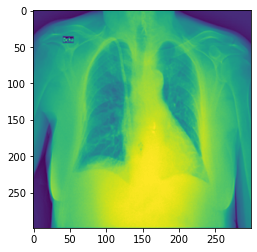

In [89]:
# Showing the image
with Image.open('/home/Universe/ML_project/Corona_detection_AWS/COVID-19_Radiography_Dataset/Dataset/test/COVID/COVID-2926.png') as image:
    plt.imshow(image)

[0.5859487056732178, 0.3381194472312927, 0.06429141014814377, 0.011640421114861965]
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


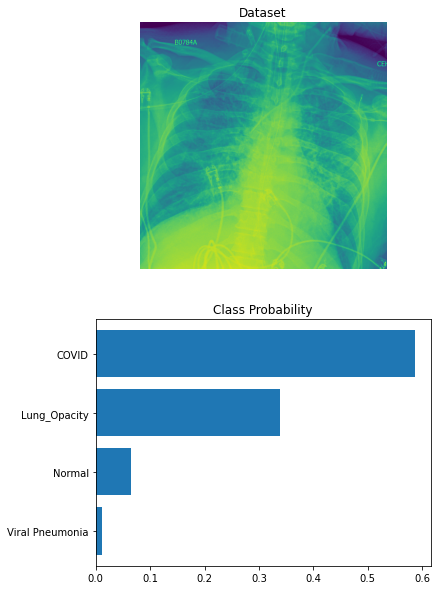

In [146]:
# 2- class prediction
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.class_to_idx = image_datasets['train'].class_to_idx

def predict2(image_path, model, topk=4):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

img_path = '/home/Universe/ML_project/Corona_detection_AWS/COVID-19_Radiography_Dataset/Dataset/covid-case-internet.jpg'
probs, classes = predict2(img_path, model.to(device))
print(probs)
#print(classes)
disease_classes = [cat_to_name[str(e)] for e in classes]
print(disease_classes)

def view_classify(img_path, prob, classes):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    disease_name = img_path.split('/')[-2]
    ax1.set_title(disease_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(disease_classes)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')


view_classify(img_path, probs, classes)

In [147]:
# To be conservative, we claim the Covid case if its probability is greater than 30 percent
for prob, claSS in zip(probs, classes):
    if (cat_to_name[str(claSS)] == 'COVID'):
        covid_prob = prob
    print("Probability of {} is {:.2f} %".format(cat_to_name[str(claSS)],prob*100))
if covid_prob > 0.3:
    print("\n\nTHIS LUNG HAS COVID")

Probability of COVID is 58.59 %
Probability of Lung_Opacity is 33.81 %
Probability of Normal is 6.43 %
Probability of Viral Pneumonia is 1.16 %


THIS LUNG HAS COVID
